In [1]:
import pandas as pd
import flair
import re
import csv
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import poisson
import math
import scipy.stats as stats
import krippendorff
import array as arr
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from flair.data import Sentence
from flair.models import SequenceTagger 
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt

/Applications/anaconda3/envs/notebook/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Validation_sample = pd.read_csv('/Users/salmankhawar/Desktop/UvA Courses/Thesis/Data_Collection_Twitter/Data_csv/Data_Collected_Tweepy/ManualCA_sample.csv')

In [4]:
CA_results = pd.read_csv('/Users/salmankhawar/Desktop/UvA Courses/Thesis/Content Analysis/Results_CA.csv')

Reading file 'AutomatedCA_sample.csv' containing sample for automated content analysis and removing urls from tweet text

In [5]:
AutomatedCA_sample = pd.read_csv('/Users/salmankhawar/Desktop/UvA Courses/Thesis/Final_data_files/samples_data_files/AutomatedCA_sample.csv')

In [3]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

Validation_sample['text'] = Validation_sample['text'].apply(lambda x: remove_URL(x))

In [6]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', 0)

## Detecting Sensationalist Features

## Hyperbole Feature

Getting list of hyperbolic words/phrases from Downworthy corpus - Gianotto, A. (2016)

In [90]:
hyperbolic_words = open("/Users/salmankhawar/Desktop/UvA Courses/Thesis/Content Analysis/Hyperbolic Words.txt", "r")
hyperbolic_words_list = hyperbolic_words.readlines()

hyperbolic_list=[]
for words in hyperbolic_words_list:
    hyperbolic_list.append(words.strip())
    
print(hyperbolic_list) 

['A Single', 'Absolutely', 'Amazing', 'Awesome', 'Best', 'Breathtaking', 'But what happened next', 'Can change your life', "Can't Even Handle", "Can't Handle", 'Cannot Even Handle', "Doesn't want you to see", 'Epic', 'Everything You Need To Know', 'Gasp-Worthy', 'Go Viral', 'Greatest', 'Incredible', 'Infuriate', 'Literally', 'Mind Blowing', 'Mind BLOWN', 'Mind Blown', 'Need To Visit Before You Die', 'Nothing Could Prepare Me For', 'Of All Time', 'OMG', 'One Weird Trick', 'Perfection', 'Priceless', 'Prove', 'Right Now', 'Scientific Reasons', 'Shocked', 'Shocking', 'Simple Lessons', "Stop What You're Doing", 'TERRIFYING', 'Terrifying', 'That Will Make You Rethink', "The World's Best", 'This Is What Happens', 'Totally blew my mind', 'Unbelievable', 'Unimaginable', 'WHAT?', 'Whoa', 'WHOA', 'Whoah', 'Will Blow Your Mind', 'Will Change Your Life Forever', 'Won the Internet', 'Wonderful', 'Worst', 'Wow', 'WOW', "You Didn't Know Exist", "You Didn't Know Existed", "You Won't Believe", 'Have To 

In [91]:
def hyperbole_detection1(tweet, query):
    tweet = str(tweet).lower()
    newquery = []
    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", tweet)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

Detecting tweets with superlatives - POS tags: RBS (superlative adverbs) and JJS (superlative adjectives)

In [98]:
tagger = SequenceTagger.load("flair/pos-english")
#tagger = SequenceTagger.load("flair/pos-english-fast")

def hyperbole_detections2(txt):
    sentence = Sentence(txt)
    tagger.predict(sentence)
    text = str(txt).lower()
    
    for label in sentence.get_labels('pos'):
        if label.value == "RBS" or label.value == "JJS":
           return 1
        
        else:
           return 0


2024-05-17 02:02:44,201 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [94]:
AutomatedCA_sample['hyperbolic_feature_1'] = AutomatedCA_sample['text'].apply(hyperbole_detection1, args=(hyperbolic_list,))

In [95]:
AutomatedCA_sample['hyperbolic_feature_2'] = AutomatedCA_sample['text'].apply(hyperbole_detections2)

Consolidating results for the approaches

In [96]:
hyperbole_grid = AutomatedCA_sample[['hyperbolic_feature_1', 'hyperbolic_feature_2']]
hyperbole_grid = np.array(hyperbole_grid)
hyperbole_grid = hyperbole_grid.tolist()
any_row_1 = [int(any(row)) for row in hyperbole_grid]
AutomatedCA_sample['hyperbolic_feature'] = any_row_1

Detection Rate = 2.66%

In [97]:
AutomatedCA_sample['hyperbolic_feature'].value_counts(normalize=True)*100


hyperbolic_feature
0    97.34375
1    2.65625 
Name: proportion, dtype: float64

In [99]:
Validation_sample['hyperbolic_feature_aca_1'] = Validation_sample['text'].apply(hyperbole_detection1, args=(hyperbolic_list,))

In [100]:
Validation_sample['hyperbolic_feature_aca_2'] = Validation_sample['text'].apply(hyperbole_detections2)

In [101]:
hyperbole_grid_val = Validation_sample[['hyperbolic_feature_aca_1', 'hyperbolic_feature_aca_2']]
hyperbole_grid_val = np.array(hyperbole_grid_val)
hyperbole_grid_val = hyperbole_grid_val.tolist()
any_row_2 = [int(any(row)) for row in hyperbole_grid_val]
Validation_sample['hyperbolic_feature_aca'] = any_row_2

Validation Metrics

In [102]:
y_test_hyp = CA_results["[hyperbolic_feature]"]
y_pred_hyp = Validation_sample["hyperbolic_feature_aca"]
confusion_matrix(y_test_hyp, y_pred_hyp)

array([[1287,    8],
       [ 111,   34]])

In [103]:
print("F1-score:", f1_score(y_test_hyp, y_pred_hyp, average="macro"))
print("Precision:", precision_score(y_test_hyp, y_pred_hyp, average="macro"))
print("Recall:", recall_score(y_test_hyp, y_pred_hyp, average="macro"))

F1-score: 0.6597238632143942
Precision: 0.865062333946454
Recall: 0.6141525762215417


In [104]:
print(classification_report(y_test_hyp, y_pred_hyp))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1295
           1       0.81      0.23      0.36       145

    accuracy                           0.92      1440
   macro avg       0.87      0.61      0.66      1440
weighted avg       0.91      0.92      0.90      1440



In [105]:
rho, p_value = stats.spearmanr(CA_results["[hyperbolic_feature]"], Validation_sample["hyperbolic_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.4082783653412781


In [106]:
array_hyperbole = [CA_results["[hyperbolic_feature]"], Validation_sample["hyperbolic_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_hyperbole))

Krippendorff's alpha: 0.31968402930155626


In [107]:
Validation_sample[Validation_sample['hyperbolic_feature_aca'] == 1]['text'].head(10)

27     FYI: Andy Cohen Was Actually The Best Part About The Billboard Music Awards And Here Are The Receipts                                                                                                                                                
40     The Dodgers win 2-1, outlasting the #SFGiants in an epic game                                                                                                                                                                                        
48     The only thing more terrifying than #Candyman, a half-dead boogeyman, covered in bees with a hook for a hand, brutally murdering people who say his name five times, is the reason he came to be that way: racism.                                   
158    With guards Kiki Rice and Londynn Jones, forward Gabriela Jaquez and centers Christeen Iwuala and Lina Sontag submitting their national letters of intent last week, the Bruins have what might be their best class ever under coach Cori 

## Forward Referencing Feature

Detecting tweets starting with commonly used forward referencing phrases, e.g demonstrative pronouns or adjectives

In [28]:
forwardref_list = ['This','That','These','Those','Here','Meet','Read']

In [29]:
def forwardref_detection(text):
    texts = sent_tokenize(text)
    for i in texts:
        if i.startswith(tuple(forwardref_list)):
            return 1
    return 0

In [30]:
AutomatedCA_sample['text'] = AutomatedCA_sample['text'].apply(str)

In [31]:
AutomatedCA_sample['forwardref_feature'] = AutomatedCA_sample['text'].apply(forwardref_detection)

Detection Rate = 4.43%

In [32]:
AutomatedCA_sample['forwardref_feature'].value_counts(normalize=True)*100

forwardref_feature
0    95.566406
1    4.433594 
Name: proportion, dtype: float64

In [33]:
Validation_sample['forwardref_feature_aca'] = Validation_sample['text'].apply(forwardref_detection)

Validation Metrics

In [34]:
y_test_lst = CA_results["[forw_ref_feature]"]
y_pred_lst = Validation_sample["forwardref_feature_aca"]
confusion_matrix(y_test_lst, y_pred_lst)

array([[1352,   28],
       [  16,   44]])

In [35]:
print("F1-score:", f1_score(y_test_lst, y_pred_lst, average="macro"))
print("Precision:", precision_score(y_test_lst, y_pred_lst, average="macro"))
print("Recall:", recall_score(y_test_lst, y_pred_lst, average="macro"))

F1-score: 0.8253275109170306
Precision: 0.7997076023391814
Recall: 0.8565217391304347


In [36]:
print(classification_report(y_test_lst, y_pred_lst))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1380
           1       0.61      0.73      0.67        60

    accuracy                           0.97      1440
   macro avg       0.80      0.86      0.83      1440
weighted avg       0.97      0.97      0.97      1440



In [37]:
rho, p_value = stats.spearmanr(CA_results["[forw_ref_feature]"], Validation_sample["forwardref_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.6537653267544177


In [38]:
array_listicle = [CA_results["[forw_ref_feature]"], Validation_sample["forwardref_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_listicle))

Krippendorff's alpha: 0.6507763221737022


In [39]:
Validation_sample[Validation_sample['forwardref_feature_aca'] == 1]['text'].head(10)

7      This is the second setback Democrats have faced in trying to include immigration in the reconciliation package.\n\n                                                          
15     Meet The Young Influencers Making Socialism Cool On TikTok                                                                                                                   
16     The Times asked four staffers who’ve been watching the Tokyo Games on TV to answer a simple question: How would you fix the Olympics?\n\nHere are their answers.             
41     There's Growing Panic That Trump Will Rush A Vaccine To Save His Presidency. That's Unlikely.                                                                                
53     Here’s Trump Allies’ Plan To Meddle In The 2020 Democratic Primary                                                                                                           
60     The sunshine state is now leading the nation in per capita hospitalizations. This follow

## Listicle Feature

Detecting tweets with digits

In [17]:
def listicle_detection(text):
    text = str(text)
    if re.findall(r"^\d{1,3}\s", text):
            return 1
    return 0

In [18]:
AutomatedCA_sample['listicle_feature'] = AutomatedCA_sample['text'].apply(listicle_detection)

Detection Rate = .77%

In [129]:
AutomatedCA_sample['listicle_feature'].value_counts(normalize=True)*100

listicle_feature
0    99.226562
1    0.773438 
Name: proportion, dtype: float64

In [20]:
Validation_sample['listicle_feature_aca'] = Validation_sample['text'].apply(listicle_detection)

Validation Metrics

In [21]:
y_test_lst = CA_results["[listicle_feature]"]
y_pred_lst = Validation_sample["listicle_feature_aca"]
confusion_matrix(y_test_lst, y_pred_lst)

array([[1426,    1],
       [   4,    9]])

In [22]:
print("F1-score:", f1_score(y_test_lst, y_pred_lst, average="macro"))
print("Precision:", precision_score(y_test_lst, y_pred_lst, average="macro"))
print("Recall:", recall_score(y_test_lst, y_pred_lst, average="macro"))

F1-score: 0.8904293040738993
Precision: 0.9486013986013986
Recall: 0.8458034607298798


In [23]:
print(classification_report(y_test_lst, y_pred_lst))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1427
           1       0.90      0.69      0.78        13

    accuracy                           1.00      1440
   macro avg       0.95      0.85      0.89      1440
weighted avg       1.00      1.00      1.00      1440



In [24]:
rho, p_value = stats.spearmanr(CA_results["[listicle_feature]"], Validation_sample["listicle_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.7877256276766114


In [25]:
array_listicle = [CA_results["[listicle_feature]"], Validation_sample["listicle_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_listicle))

Krippendorff's alpha: 0.7809346989088585


In [26]:
Validation_sample[Validation_sample['listicle_feature_aca'] == 1]['text']

58      26 Emo And Pop-Punk Songs You Need On Your Workout Playlist                                                                                
80      28 Shows Premiering On Netflix, Amazon, Hulu, And HBO This Summer                                                                          
83      15 Celebrity Tweets You Missed This Week                                                                                                   
119     35 Facts That Every "Golden Girls" Fanatic Should Know                                                                                     
223     13 Serious Questions I Have About "13 Going On 30" As An Adult                                                                             
472     22 Pop Culture Moments That You Might Have Forgotten Happened In July 2008                                                                 
593     100 Hilarious Posts That Prove Tumblr Is The Best When It Comes To Disney                               

## Question Feature

Detecting interrogative structure in tweets, i.e presence of a question mark

In [40]:
def question_detection(text):
    text = str(text)
    if re.search('\w{1,}[?][,";@#]?', text):
        return 1
    return 0

In [41]:
AutomatedCA_sample['question_feature'] = AutomatedCA_sample['text'].apply(question_detection)

Detection Rate= 5.34%

In [42]:
AutomatedCA_sample['question_feature'].value_counts(normalize=True)*100

question_feature
0    94.660156
1    5.339844 
Name: proportion, dtype: float64

In [43]:
Validation_sample['question_feature_aca'] = Validation_sample['text'].apply(question_detection)

Validation Metrics

In [44]:
y_test_q = CA_results["[question_feature]"]
y_pred_q = Validation_sample["question_feature_aca"]
confusion_matrix(y_test_q, y_pred_q)

array([[1357,    3],
       [   2,   78]])

In [45]:
print("F1-score:", f1_score(y_test_q, y_pred_q, average="macro"))
print("Precision:", precision_score(y_test_q, y_pred_q, average="macro"))
print("Recall:", recall_score(y_test_q, y_pred_q, average="macro"))

F1-score: 0.983552594007205
Precision: 0.9807456463085602
Recall: 0.9863970588235293


In [46]:
print(classification_report(y_test_q, y_pred_q))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1360
           1       0.96      0.97      0.97        80

    accuracy                           1.00      1440
   macro avg       0.98      0.99      0.98      1440
weighted avg       1.00      1.00      1.00      1440



In [47]:
rho, p_value = stats.spearmanr(CA_results["[question_feature]"], Validation_sample["question_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.9671261932275446


In [48]:
array_question = [CA_results["[question_feature]"], Validation_sample["question_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_question))  

Krippendorff's alpha: 0.967116609824127


## All-Caps Feature

Using part of speech tagging to identify capitalized proper nouns/acronyms (POS tag: NNP) in the sample, and excluding them in detection of the all-caps feature

In [115]:
tagger = SequenceTagger.load("flair/pos-english")
#tagger = SequenceTagger.load("flair/pos-english-fast")

tag_list = []
def pos_tagg_ex(txt):
    sentence = Sentence(txt)
    tagger.predict(sentence)

    for label in sentence.get_labels('pos'):
        if label.value == "NNP":
            if label.data_point.text.isupper():
                tag_list.append(label.data_point.text)
        else:
          pass
            


2024-05-17 03:15:50,567 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD


In [109]:
AutomatedCA_sample['text'].apply(pos_tagg_ex);

In [110]:
tag_list_upper = list(set(tag_list))
print(len(tag_list_upper))
tag_list_upper[:20]

1030


['AG',
 'INIESTA',
 'TBT',
 'PARIS',
 'KANSAS',
 'CAIR-OK',
 'MMA',
 'AUSTIN',
 'COVID',
 'VI',
 'U.S.A',
 'BD',
 'AFCA',
 'IRL',
 'ALS',
 'VIDEO',
 'RIP',
 'PSA',
 'KILLINGEVE',
 'S1',
 'USPS',
 'NEW',
 'F',
 'KCMO',
 'GDP',
 'HARRIET',
 'RS',
 'TO',
 'LMA',
 'STILL',
 'IBS',
 'M.J',
 'L',
 'IRA',
 'KUWTK',
 'HTGAWM',
 'ODNI',
 'WH',
 'PG13',
 'NBATV']

In [112]:
def capitalized_detection(text):
    text = str(text)
    
    m = re.findall(r"\b[A-Z]{2,}\b", text)
    if m:
        if any(x in m for x in tag_list_upper):
                       return 0
             
        else: 
                       return 1
            
    else:
        return 0

In [113]:
AutomatedCA_sample['capitalized_feature_aca'] = AutomatedCA_sample['text'].apply(capitalized_detection) 

Detection Rate = 0.88%

In [114]:
AutomatedCA_sample['capitalized_feature_aca'].value_counts(normalize=True)*100

capitalized_feature_aca
0    99.125
1    0.875 
Name: proportion, dtype: float64

In [116]:
Validation_sample['text'].apply(pos_tagg_ex);

In [117]:
tag_list_upper = list(set(tag_list))
print(len(tag_list_upper))
tag_list_upper[:20]

195


['AAA',
 'BTS',
 'CEO',
 'CIA',
 'KANSAS',
 'D.C.',
 'TIFF18',
 'DGA',
 'COVID',
 'MIB',
 'A',
 'VIDEO',
 'NEW',
 'PSA',
 'PAW',
 'FRANCE',
 'NICKIMINAJ',
 'K2TR',
 'M.J',
 'OC']

In [118]:
Validation_sample['capitalized_feature_aca'] = Validation_sample['text'].apply(capitalized_detection) 

Validation Metrics

In [119]:
y_test_cap = CA_results["[cap_feature]"]
y_pred_cap = Validation_sample["capitalized_feature_aca"]
confusion_matrix(y_test_cap, y_pred_cap)

array([[1388,    8],
       [  24,   20]])

In [120]:
print("F1-score:", f1_score(y_test_cap, y_pred_cap, average="macro"))
print("Precision:", precision_score(y_test_cap, y_pred_cap, average="macro"))
print("Recall:", recall_score(y_test_cap, y_pred_cap, average="macro"))

F1-score: 0.7720797720797721
Precision: 0.8486442735734521
Recall: 0.7244073977598333


In [121]:
print(classification_report(y_test_cap, y_pred_cap))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1396
           1       0.71      0.45      0.56        44

    accuracy                           0.98      1440
   macro avg       0.85      0.72      0.77      1440
weighted avg       0.97      0.98      0.98      1440



In [122]:
rho, p_value = stats.spearmanr(CA_results["[cap_feature]"], Validation_sample["capitalized_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.5594223956063461


In [123]:
array_caps = [CA_results["[cap_feature]"], Validation_sample["capitalized_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_caps))

Krippendorff's alpha: 0.5443178220955999


In [124]:
Validation_sample[Validation_sample['capitalized_feature_aca'] == 1]['text'].head(10)

76     FINALLY!                                                                                                                                                 
92     This guy HAD to be trolling, right? (Via @seth_rosenthal)                                                                                                
155    Spent a fair amount of time around Roger #Federer last summer. The sense was clear that he NEEDED to be locked in for #AusOpen. But this?!               
203    The Trump Cards are for the former president's "STRONGEST supporters" and folks had thoughts.                                                            
287    SPECIAL DELIVERY: Adidas' Top Ten sneaker is getting some well-deserved love with this new collab and it's about time                                    
319    Chris Taylor loves these elimination games. He hits a 2-run HR over the center-field wall, and the #Dodgers now up 6-2.                                  
325    LIVE: @DionneGrant and @sco

## Emojis Feature

Extracting list of emojis from the emoji library and creating function for detection

In [49]:
import emoji
emoji_list = list(emoji.EMOJI_DATA.keys())
len(emoji_list)

5034

In [50]:
def emoji_detection(text):
    text = str(text)
    for word in text:
        if word in emoji_list:
            return 1
    return 0

In [51]:
AutomatedCA_sample['emoji_feature'] = AutomatedCA_sample['text'].apply(emoji_detection)

Detection Rate = 2.89%

In [52]:
AutomatedCA_sample['emoji_feature'].value_counts(normalize=True)*100

emoji_feature
0    97.109375
1    2.890625 
Name: proportion, dtype: float64

In [53]:
Validation_sample['emoji_feature_aca'] = Validation_sample['text'].apply(emoji_detection) 


Validation Metrics

In [54]:
y_test_emoji = CA_results["[emoji_feature]"]
y_pred_emoji = Validation_sample["emoji_feature_aca"]
confusion_matrix(y_test_emoji, y_pred_emoji)

array([[1378,    1],
       [  16,   45]])

In [55]:
print("F1-score:", f1_score(y_test_emoji, y_pred_emoji, average="macro"))
print("Precision:", precision_score(y_test_emoji, y_pred_emoji, average="macro"))
print("Recall:", recall_score(y_test_emoji, y_pred_emoji, average="macro"))

F1-score: 0.9174954753952499
Precision: 0.9833915538643878
Recall: 0.8684898774355378


In [56]:
print(classification_report(y_test_emoji, y_pred_emoji))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1379
           1       0.98      0.74      0.84        61

    accuracy                           0.99      1440
   macro avg       0.98      0.87      0.92      1440
weighted avg       0.99      0.99      0.99      1440



In [57]:
rho, p_value = stats.spearmanr(CA_results["[emoji_feature]"], Validation_sample["emoji_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.8440969006858452


In [58]:
array_emoji = [CA_results["[emoji_feature]"], Validation_sample["emoji_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_emoji))

Krippendorff's alpha: 0.8350482455992532


In [59]:
Validation_sample[Validation_sample["emoji_feature_aca"] == 1]['text'].head(10)

121    ⚡️ “Is it time for the Dodgers to hit the reset button on their roster?” by @latimessports                                                                                         
131    Listener @frankadirector has joined our Spaces chat to share his experience as a SAG and DGA member. \n\nShare your story with us &amp; join the chat 📽️                           
132    🙏ONE DAY UNTIL @NBA IS BACK🙏                                                                                                                                                       
136    🏀🏀🏀🏀🏀🏀                                                                                                                                                                             
146    Lucy Liu in Versace at the 2000 #Emmys. That's it. That's the tweet. \n📸: ImageDirect                                                                                              
192    🚨Cardinals are on the scoreboard🚨                         

## Hashtag Feature

Using regular expressions to detect hashtags

In [60]:
def hashtag_detection(text):
    text = str(text)
    if re.search('#\w', text):
        return 1
    return 0

In [61]:
AutomatedCA_sample['hashtag_feature'] = AutomatedCA_sample['text'].apply(hashtag_detection)

Detection Rate = 8.90%

In [62]:
AutomatedCA_sample['hashtag_feature'].value_counts(normalize=True)*100

hashtag_feature
0    91.097656
1    8.902344 
Name: proportion, dtype: float64

In [63]:
Validation_sample['hashtag_feature_aca'] = Validation_sample['text'].apply(hashtag_detection)

Validation Metrics

In [64]:
y_test_hash = CA_results["[hashtag_feature]"]
y_pred_hash = Validation_sample["hashtag_feature_aca"]
confusion_matrix(y_test_hash, y_pred_hash)

array([[1315,    3],
       [   0,  122]])

In [65]:
print("F1-score:", f1_score(y_test_hash, y_pred_hash, average="macro"))
print("Precision:", precision_score(y_test_hash, y_pred_hash, average="macro"))
print("Recall:", recall_score(y_test_hash, y_pred_hash, average="macro"))

F1-score: 0.9933574331399506
Precision: 0.988
Recall: 0.9988619119878603


In [66]:
print(classification_report(y_test_hash, y_pred_hash))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1318
           1       0.98      1.00      0.99       122

    accuracy                           1.00      1440
   macro avg       0.99      1.00      0.99      1440
weighted avg       1.00      1.00      1.00      1440



In [67]:
rho, p_value = stats.spearmanr(CA_results["[hashtag_feature]"], Validation_sample["hashtag_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.9868021342702413


In [68]:
array_hashtag = [CA_results["[hashtag_feature]"], Validation_sample["hashtag_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_hashtag))

Krippendorff's alpha: 0.986719479173554


## Informal Punctuation Feature

Using regular expressions to detect unusual punctuation

In [7]:
def informalpunct_detection(text):
    text = str(text)
    pattern = '[!?*.-]{2,}|[\+]+|\*\w+\*'
    if re.search(pattern, text):
            return 1
    else:
            return 0

In [8]:
AutomatedCA_sample['informalpunct_feature'] = AutomatedCA_sample['text'].apply(informalpunct_detection) 

Detection Rate = 2.55%

In [9]:
AutomatedCA_sample['informalpunct_feature'].value_counts(normalize=True)*100

informalpunct_feature
0    97.445312
1    2.554688 
Name: proportion, dtype: float64

In [10]:
Validation_sample['informalpunct_feature_aca'] = Validation_sample['text'].apply(informalpunct_detection)

Validation Metrics

In [11]:
y_test_punct = CA_results["[punct_feature]"]
y_pred_punct = Validation_sample["informalpunct_feature_aca"]
confusion_matrix(y_test_punct, y_pred_punct)

array([[1399,    4],
       [  12,   25]])

In [12]:
print("F1-score:", f1_score(y_test_punct, y_pred_punct, average="macro"))
print("Precision:", precision_score(y_test_punct, y_pred_punct, average="macro"))
print("Recall:", recall_score(y_test_punct, y_pred_punct, average="macro"))

F1-score: 0.8759449505718162
Precision: 0.9267821794276497
Recall: 0.836412321088016


In [13]:
print(classification_report(y_test_punct, y_pred_punct))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1403
           1       0.86      0.68      0.76        37

    accuracy                           0.99      1440
   macro avg       0.93      0.84      0.88      1440
weighted avg       0.99      0.99      0.99      1440



In [14]:
rho, p_value = stats.spearmanr(CA_results["[punct_feature]"], Validation_sample["informalpunct_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.7578252663517041


In [15]:
array_punct = [CA_results["[punct_feature]"], Validation_sample["informalpunct_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_punct))

Krippendorff's alpha: 0.7519760504835131


In [16]:
Validation_sample[Validation_sample['informalpunct_feature_aca'] == 1]['text'].head(10)

31     He's just the 17th pitcher -- and 3rd lefty -- to reach the milestone in MLB history.                                                                                                                                                                              
66     Daily new case numbers are already climbing sharply in countries like the United Kingdom and Portugal -- triggering alarm across the continent.                                                                                                                    
105    Update: Seahawks beat the #Patriots, Rams beat the Seahawks, 49ers beat the Rams twice -- 49ers are #SuperBowl champs! #alternativefacts                                                                                                                           
107    It's been 20 years (!) since #LegallyBlonde premiered. Here's how @ReeseW's Elle Woods inspired an entire generation of law students... "What, like it's hard?"\n                               

## Slang Feature

Two dictionaries for slang words and abbrevations commonly appearing in tweets were used to detect this feature.

The first list was taken from https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing :

In [73]:
def slang_present(txt, query):
    newquery = []
    txt = str(txt).lower()

    for word in query:
        newquery.append(str(word).lower())
    tokens = re.findall(r"[\w']+|[.,!?;$@#]", txt)
    
    for word in newquery:
        if word in tokens:
            return 1
    return 0

In [74]:
dict1 = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [75]:
slang_dict1 = dict1.keys()
slang_dict1 = [x for x in dict1 if len(x) > 1]
len(slang_dict1)

224

The second list was taken from: https://www.kaggle.com/datasets/gogylogy/twitterslang

In [76]:
dict2 = pd.read_csv('/Users/salmankhawar/Desktop/Thesis Publication/Paper Revisions/twitterSlang.csv')
dict2

,slang,formal_translation
0,ab,about
1,abt,about
2,b/c,because
3,b,be
4,b4,before
...,...,...
99,afaik,as far as i know
100,dyk,did you know
101,fbf,flashback Friday
102,ff,follow Friday


In [77]:
slang_dict2 = dict2['slang']
slang_dict2

0      ab    
1      abt   
2      b/c   
3      b     
4      b4    
       ..    
99     afaik 
100    dyk   
101    fbf   
102    ff    
103    tgif  
Name: slang, Length: 104, dtype: object

In [78]:
def remove_space(string):
    return string.replace(" ", "")

In [79]:
slang_dict2 = list(map(remove_space, slang_dict2))

In [80]:
slang_dict2 = [x for x in slang_dict2 if len(x) > 1]
len(slang_dict2)

100

In [81]:
slang_list = slang_dict1 + slang_dict2
len(slang_list)

324

Detection Rate = 1.79%

In [88]:
AutomatedCA_sample['slang_feature'] = AutomatedCA_sample['text'].apply(slang_present, args=(slang_list,))

In [89]:
AutomatedCA_sample['slang_feature'].value_counts(normalize=True)*100

slang_feature
0    98.207031
1    1.792969 
Name: proportion, dtype: float64

In [82]:
Validation_sample['slang_feature_aca'] = Validation_sample['text'].apply(slang_present,args=(slang_list,))

Validation Metrics

In [83]:
y_test_slang = CA_results["[slang_feature]"]
y_pred_slang = Validation_sample["slang_feature_aca"]
confusion_matrix(y_test_slang, y_pred_slang)

array([[1342,   14],
       [  67,   17]])

In [84]:
print("F1-score:", f1_score(y_test_slang, y_pred_slang, average="macro"))
print("Precision:", precision_score(y_test_slang, y_pred_slang, average="macro"))
print("Recall:", recall_score(y_test_slang, y_pred_slang, average="macro"))

F1-score: 0.6331787090180045
Precision: 0.7504178209208086
Recall: 0.5960282343025706


In [85]:
print(classification_report(y_test_slang, y_pred_slang))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1356
           1       0.55      0.20      0.30        84

    accuracy                           0.94      1440
   macro avg       0.75      0.60      0.63      1440
weighted avg       0.93      0.94      0.93      1440



In [86]:
rho, p_value = stats.spearmanr(CA_results["[slang_feature]"], Validation_sample["slang_feature_aca"])
 
print("Spearman rank correlation:", rho)

Spearman rank correlation: 0.3101430713778567


In [87]:
array_slang = [CA_results["[slang_feature]"], Validation_sample["slang_feature_aca"]]
print("Krippendorff's alpha:", krippendorff.alpha(array_slang))


Krippendorff's alpha: 0.26661215504363545


## Media

In [69]:
AutomatedCA_sample['media_type'].value_counts(normalize=True)*100

media_type
no media        81.898438
photo           13.746094
video           2.734375 
animated_gif    1.621094 
Name: proportion, dtype: float64

In [70]:
def media_feature(x):
        if x == 'no media':
            return 0
        else:
            return 1

In [71]:
AutomatedCA_sample['media_dummy'] = AutomatedCA_sample['media_type'].apply(media_feature) 

Detection Rate = 18.10%

In [72]:
AutomatedCA_sample['media_dummy'].value_counts(normalize=True)*100

media_dummy
0    81.898438
1    18.101562
Name: proportion, dtype: float64

## Hypotheses Testing

## H1: News Outlet Type (Legacy vs. Online-Native) and the Use of Sensationalist Features 

In [125]:
legacy_outlets = ['USA TODAY Politics', 'USA TODAY Sports', 'USA TODAY Life', 'L.A. Times Politics', 'L.A. Times Sports', 'LAT Entertainment']
regex_legacy_outlets = re.compile("(?=(" + "|".join(map(re.escape, legacy_outlets)) + "))")

In [126]:
def news_outlet_classification(noc):
    noc = str(noc)
    m=re.search(regex_legacy_outlets, noc)
    if m:
        return 0
    else:
        return 1

In [127]:
AutomatedCA_sample['outlet_type'] = AutomatedCA_sample['twitter_account'].apply(news_outlet_classification) 

In [128]:
AutomatedCA_sample['outlet_type'].value_counts()

outlet_type
1    12800
0    12800
Name: count, dtype: int64

In [130]:
features_grid = AutomatedCA_sample[['hyperbolic_feature', 'slang_feature', 'listicle_feature', 'emoji_feature', 'question_feature', 'hashtag_feature', 'forwardref_feature', 'informalpunct_feature', 'capitalized_feature_aca', 'media_dummy']]


In [131]:
features_grid = np.array(features_grid)
features_grid = features_grid.tolist()
any_row = [int(any(row)) for row in features_grid]
AutomatedCA_sample['combined_features_dummy'] = any_row

At least one sensationalist feature present in 36.05% of tweets

In [132]:
AutomatedCA_sample['combined_features_dummy'].value_counts(normalize=True)*100

combined_features_dummy
0    63.949219
1    36.050781
Name: proportion, dtype: float64

In [133]:
count_variable = np.sum(features_grid ,axis=1).tolist()

In [134]:
AutomatedCA_sample['count_variable'] = count_variable
AutomatedCA_sample['count_variable'].value_counts(normalize=True)*100

count_variable
0    63.949219
1    26.492187
2    7.363281 
3    1.757812 
4    0.367188 
5    0.062500 
6    0.007812 
Name: proportion, dtype: float64

In [135]:
def pol_ent_classification(x):
    x = str(x)
    if re.search('(Politics)', x):
        return 0
    else:
        return 1

In [136]:
AutomatedCA_sample['channel_type'] = AutomatedCA_sample['twitter_account'].apply(pol_ent_classification) 
AutomatedCA_sample['channel_type'].value_counts()

channel_type
0    12800
1    12800
Name: count, dtype: int64

In [137]:
def length_tweet(x):
    x = str(x)
    return len(x)

In [138]:
AutomatedCA_sample['len_tweet'] = AutomatedCA_sample['text'].apply(length_tweet) 

In [139]:
features_h1 = ['outlet_type','channel_type','len_tweet']

In [140]:
logit_model = sm.Logit(AutomatedCA_sample['combined_features_dummy'], sm.add_constant(AutomatedCA_sample[features_h1]))
ACAreg_modelH1a = logit_model.fit()
print(ACAreg_modelH1a.summary())

Optimization terminated successfully.
         Current function value: 0.566736
         Iterations 6
                              Logit Regression Results                             
Dep. Variable:     combined_features_dummy   No. Observations:                25600
Model:                               Logit   Df Residuals:                    25596
Method:                                MLE   Df Model:                            3
Date:                     Fri, 17 May 2024   Pseudo R-squ.:                  0.1330
Time:                             03:47:37   Log-Likelihood:                -14508.
converged:                            True   LL-Null:                       -16735.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.1317      0.047    -45.727      0.000      -2

In [141]:
Poisson_Regression_H1 = sm.Poisson(AutomatedCA_sample['count_variable'], sm.add_constant(AutomatedCA_sample[features_h1]))
ACApoiss_modelH1 = Poisson_Regression_H1.fit()
print(ACApoiss_modelH1.summary())

Optimization terminated successfully.
         Current function value: 0.832426
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:         count_variable   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25596
Method:                           MLE   Df Model:                            3
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1072
Time:                        03:54:06   Log-Likelihood:                -21310.
converged:                       True   LL-Null:                       -23868.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.0058      0.032    -62.555      0.000      -2.069      -1.943
outlet_type      0.5887

## H2: Sensationalist Features and Engagement Metrics 

In [142]:
features_h2a = ['count_variable','outlet_type','channel_type','len_tweet']

In [143]:
Poisson_Regression_H2a = sm.Poisson(AutomatedCA_sample['favorite_count'], sm.add_constant(AutomatedCA_sample[features_h2a]))
ACApoiss_modelH2a = Poisson_Regression_H2a.fit()
print (ACApoiss_modelH2a.summary())

Optimization terminated successfully.
         Current function value: 31.774077
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:         favorite_count   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25595
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 May 2024   Pseudo R-squ.:                 0.05006
Time:                        03:54:47   Log-Likelihood:            -8.1342e+05
converged:                       True   LL-Null:                   -8.5628e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.0974      0.006    353.091      0.000       2.086       2.109
count_variable  

In [144]:
Poisson_Regression_H2b = sm.Poisson(AutomatedCA_sample['retweet_count'], sm.add_constant(AutomatedCA_sample[features_h2a]))
ACApoiss_modelH2b = Poisson_Regression_H2b.fit()
print (ACApoiss_modelH2b.summary())

Optimization terminated successfully.
         Current function value: 109.956074
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:          retweet_count   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25595
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1806
Time:                        03:55:40   Log-Likelihood:            -2.8149e+06
converged:                       True   LL-Null:                   -3.4351e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.9211      0.005    366.638      0.000       1.911       1.931
count_variable 

In [145]:
features_h2b = ['combined_features_dummy','outlet_type','channel_type','len_tweet']

In [146]:
Poisson_Regression_H2c = sm.Poisson(AutomatedCA_sample['favorite_count'], sm.add_constant(AutomatedCA_sample[features_h2b]))
ACApoiss_modelH2c = Poisson_Regression_H2c.fit()
print(ACApoiss_modelH2c.summary())

Optimization terminated successfully.
         Current function value: 31.849503
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:         favorite_count   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25595
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 May 2024   Pseudo R-squ.:                 0.04781
Time:                        03:56:19   Log-Likelihood:            -8.1535e+05
converged:                       True   LL-Null:                   -8.5628e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.1050      0.006    352.874      0.000       2.093  

In [147]:
Poisson_Regression_H2d = sm.Poisson(AutomatedCA_sample['retweet_count'], sm.add_constant(AutomatedCA_sample[features_h2b]))
ACApoiss_modelH2d = Poisson_Regression_H2d.fit()
print(ACApoiss_modelH2d.summary())

Optimization terminated successfully.
         Current function value: 110.658446
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:          retweet_count   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25595
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.1753
Time:                        03:56:33   Log-Likelihood:            -2.8329e+06
converged:                       True   LL-Null:                   -3.4351e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.8680      0.005    355.895      0.000       1.858 

In [148]:
aca_features_indiv = ['hyperbolic_feature','slang_feature','listicle_feature','emoji_feature','question_feature','hashtag_feature','informalpunct_feature','forwardref_feature','media_dummy','capitalized_feature_aca', 'channel_type','outlet_type','len_tweet']


In [149]:
Poisson_Regression_H2e = sm.Poisson(AutomatedCA_sample['favorite_count'], sm.add_constant(AutomatedCA_sample[aca_features_indiv]))
ACApoiss_modelH2e = Poisson_Regression_H2e.fit()
print (ACApoiss_modelH2e.summary())

Optimization terminated successfully.
         Current function value: 31.332194
         Iterations 6
                          Poisson Regression Results                          
Dep. Variable:         favorite_count   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25586
Method:                           MLE   Df Model:                           13
Date:                Fri, 17 May 2024   Pseudo R-squ.:                 0.06327
Time:                        03:58:18   Log-Likelihood:            -8.0210e+05
converged:                       True   LL-Null:                   -8.5628e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.0398      0.006    331.624      0.000       2.028  

In [150]:
Poisson_Regression_H2f = sm.Poisson(AutomatedCA_sample['retweet_count'], sm.add_constant(AutomatedCA_sample[aca_features_indiv]))
ACApoiss_modelH2f = Poisson_Regression_H2f.fit()
print (ACApoiss_modelH2f.summary())

Optimization terminated successfully.
         Current function value: 105.561857
         Iterations 13
                          Poisson Regression Results                          
Dep. Variable:          retweet_count   No. Observations:                25600
Model:                        Poisson   Df Residuals:                    25586
Method:                           MLE   Df Model:                           13
Date:                Fri, 17 May 2024   Pseudo R-squ.:                  0.2133
Time:                        03:58:21   Log-Likelihood:            -2.7024e+06
converged:                       True   LL-Null:                   -3.4351e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.8677      0.005    352.896      0.000       1.857

## Visualizations

In [151]:
AutomatedCA_sample['count_variable'].value_counts(normalize=True)*100

count_variable
0    63.949219
1    26.492187
2    7.363281 
3    1.757812 
4    0.367188 
5    0.062500 
6    0.007812 
Name: proportion, dtype: float64

<Figure size 640x480 with 0 Axes>

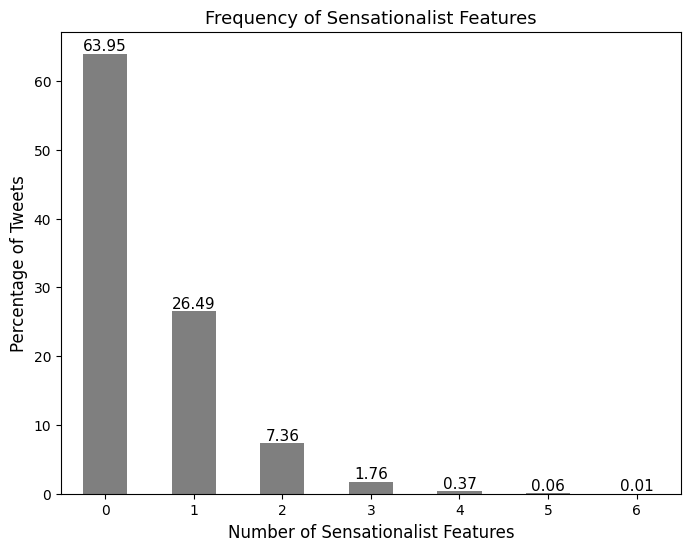

In [185]:
#x-axis
features = [0,1,2,3,4,5,6]

#y-axis
frequency = [63.95,26.49,7.36,1.76,0.37,0.06,0.01]

frequency_series = pd.Series(frequency)

x_labels = [0,1,2,3,4,5,6]


fig = plt.figure()

# Plotting the bar chart

plt.figure(figsize=(8, 6))
plt.xlabel("Number of Sensationalist Features",fontsize=12)
plt.ylabel("Percentage of Tweets",fontsize=12)
plt.title("Frequency of Sensationalist Features", fontsize=13)
fig = frequency_series.plot(kind='bar', color='#7F7F7F')
fig.set_xticklabels(x_labels,rotation=0)
fig.bar_label(fig.containers[0], label_type='edge',fontsize=11)


plt.savefig("/Users/salmankhawar/Desktop/Thesis Publication/Paper Revisions/Paper Revisions 2/Frequency_Sensationalist.jpg", dpi = 300)
#plt.show()

In [160]:
len(AutomatedCA_sample.loc[(AutomatedCA_sample['outlet_type'] == 1) & (AutomatedCA_sample['combined_features_dummy'] == 1)])/(len(AutomatedCA_sample.loc[(AutomatedCA_sample['outlet_type'] == 1)])) * 100


45.875

In [161]:
len(AutomatedCA_sample.loc[(AutomatedCA_sample['outlet_type'] == 0) & (AutomatedCA_sample['combined_features_dummy'] == 1)])/(len(AutomatedCA_sample.loc[(AutomatedCA_sample['outlet_type'] == 0)])) * 100


26.2265625

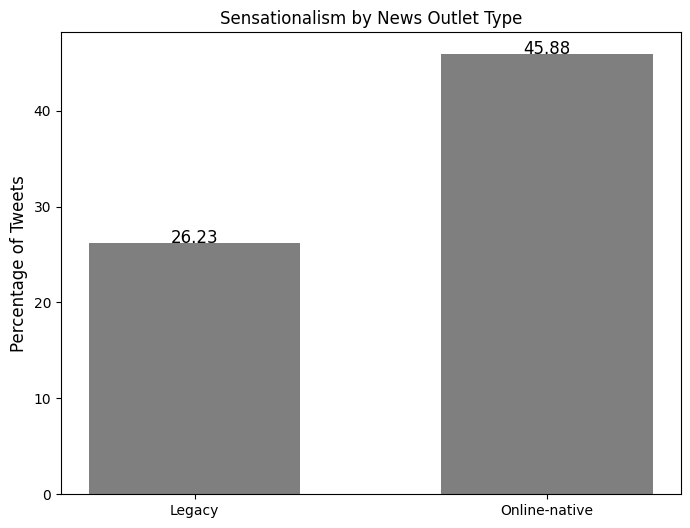

In [183]:
x = np.array(["Legacy", "Online-native"])
y = np.array([26.23,45.88])

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',fontsize=12)
        
plt.figure(figsize=(8,6)) 
        
plt.bar(x,y,color='#7F7F7F', width=0.6)

addlabels(x, y)
     
plt.title("Sensationalism by News Outlet Type", fontsize=12)
     
plt.ylabel("Percentage of Tweets",fontsize=12)




plt.savefig("/Users/salmankhawar/Desktop/Thesis Publication/Paper Revisions/Paper Revisions 2/Sensationalism_Outlet_Type.jpg", dpi = 300)